### 버전 기록_ DUMMY
- Model Baseline 코드 (2024.12.30)
- Drug Graph, Drug Graph Embedding Block 추가 (2025.01.01)
- Dummy Data로 교체 (25.01.02)
- Train, Valid, Test 추가 (25.01.02)
- Pathway Graph, Pathway Graph Embedding Block 추가 (2025.01.03)
- 연산 최적화 (모델 내 for문 제거, 텐서 연산 활용)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn.functional as F
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

In [2]:
num_cell_lines = 10
num_pathways = 5
num_genes = 15
num_drugs = 7
num_substructures = 12

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"CUDA is available: {torch.cuda.is_available()}")

CUDA is available: True


# 1. 데이터

### (1) Gene Embedding Dictionary 
Cell Line → gene embeddings (num_pathways, num_genes)

In [4]:
gene_embeddings = {
    f"DATA.{i}": torch.rand(num_pathways, num_genes, dtype=torch.float32)
    for i in range(num_cell_lines)
}

gene_embeddings['DATA.1'].shape

torch.Size([5, 15])

### (2) Drug Embedding Dictionary
CID → drug embeddings (num_substructures)

In [5]:
drug_embeddings = {
    f"{i}": torch.rand(num_substructures, dtype=torch.float32)
    for i in range(num_drugs)
}

drug_embeddings['1'].shape

torch.Size([12])

### (3) Drug Graph Dictionary
CID → drug graph (pytorch geomeric data)

In [6]:
# Create dummy data for drug_graphs
drug_graph_dict = {
    f"{i}": Data(
        x=torch.rand(num_substructures, 5),  # Node features
        edge_index=torch.randint(0, num_substructures, (2, 12)),  # Random edges
        global_ids=list(range(num_substructures))
    )
    for i in range(num_drugs)
}

print(drug_graph_dict['1'])

Data(x=[12, 5], edge_index=[2, 12], global_ids=[12])


## (4) Pathway Graph List
pathway graph list (pytorch geometric data)

In [7]:
# Create dummy data for pathway_graphs
pathway_graph_list = [
        Data(
            x=torch.rand(num_genes, 128),  
            edge_index=torch.randint(0, num_genes, (2, 15)), 
            global_ids=list(range(num_genes))
        )
        for _ in range(num_pathways)  
]

# Print an example pathway graph for pathway_1
print(pathway_graph_list)

[Data(x=[15, 128], edge_index=[2, 15], global_ids=[15]), Data(x=[15, 128], edge_index=[2, 15], global_ids=[15]), Data(x=[15, 128], edge_index=[2, 15], global_ids=[15]), Data(x=[15, 128], edge_index=[2, 15], global_ids=[15]), Data(x=[15, 128], edge_index=[2, 15], global_ids=[15])]


In [8]:
substructure_embeddings = {
    drug: torch.rand(10) for drug in drug_embeddings.keys()
}

# 모든 cell line과 drug의 조합 생성
cell_lines = list(gene_embeddings.keys())
drugs = list(drug_embeddings.keys())
sample_indices = list(product(cell_lines, drugs)) 

# Cell line과 drug의 매핑
cell_line_mapping = {key: idx for idx, key in enumerate(gene_embeddings.keys())}
drug_mapping = {cid: idx for idx, cid in enumerate(drug_graph_dict.keys())}

### (4) Labels

In [9]:
labels = torch.randint(0, 2, (num_cell_lines, num_drugs), dtype=torch.float32)

def convert_labels_to_dict(labels_tensor, cell_line_mapping, drug_mapping):
    labels_dict = {}
    for cell_line_idx, cell_line_id in enumerate(cell_line_mapping.keys()):
        for drug_idx, drug_id in enumerate(drug_mapping.keys()):
            labels_dict[(cell_line_id, drug_id)] = labels_tensor[cell_line_idx, drug_idx].item()
    return labels_dict

# 딕셔너리로 라벨 변환
labels_dict = convert_labels_to_dict(labels, cell_line_mapping, drug_mapping)

print(len(labels_dict))

70


# 2. Dataset

In [10]:
class DrugResponseDataset(Dataset):
    def __init__(self, gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs, labels, sample_indices):
        """
        Args:
            gene_embeddings (dict): {cell_line_id: Tensor}, Gene embeddings for each cell line.
            drug_graphs (dict): List of PyTorch Geometric Data objects for each drug (indexed by drug_id).
            substructure_embeddings (Tensor): [245, 193], Substructure embeddings for pathways.
            labels (dict): {cell_line_id: Tensor}, Drug response labels for each cell line and drug pair.
            sample_indices (list): [(cell_line_id, drug_idx)], List of cell line and drug index pairs.
        """
        self.gene_embeddings = gene_embeddings  # {cell_line_id: [245, 231]}
        self.pathway_graphs = pathway_graphs
        self.drug_graphs = drug_graphs  # Drug graphs
        self.substructure_embeddings = substructure_embeddings  # [170]
        self.labels = labels  # {cell_line_id, drug_id : [1]}
        self.sample_indices = sample_indices  # [(cell_line_id, drug_id)]


    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        cell_line_id, drug_id = self.sample_indices[idx]

        # Gene embeddings for the cell line
        gene_embedding = self.gene_embeddings[cell_line_id]  # [245, 231]
        pathway_graph = self.pathway_graphs  # Pathway graphs

        # Substructure embeddings for pathways
        substructure_embedding = self.substructure_embeddings[drug_id].repeat(num_pathways, 1)  # [1, 170]
        drug_graph = self.drug_graphs[drug_id]  # Drug graphs

        # Get the label for the cell line-drug pair
        label = self.labels[cell_line_id, drug_id]  # Scalar

        return {
            'gene_embedding': gene_embedding,  # [245, 231]
            'pathway_graph': pathway_graph,                     # List of PyTorch Geometric Data objects
            'substructure_embedding': substructure_embedding,  # [245, 170]
            'drug_graph': drug_graph,  # PyTorch Geometric Data object
            'label': label  # Scalar
        }

In [11]:
from torch_geometric.data import Batch

def collate_fn(batch):
    gene_embeddings = []
    substructure_embeddings = []
    drug_graphs = []
    labels = []
    
    for item in batch:
        gene_embeddings.append(item['gene_embedding'])
        substructure_embeddings.append(item['substructure_embedding'])
        drug_graphs.append(item['drug_graph'])
        labels.append(item['label'])

    pathway_graph = batch[0]['pathway_graph'] 
    pathway_batch = Batch.from_data_list(pathway_graph)
    drug_batch = Batch.from_data_list(drug_graphs)

    return {
        'gene_embeddings': torch.stack(gene_embeddings),  # [batch_size, num_pathways, num_genes]
        'pathway_graphs': pathway_batch,  
        'substructure_embeddings': torch.stack(substructure_embeddings),  # [batch_size, num_pathways, num_substructures]
        'drug_graphs': drug_batch, # PyTorch Geometric Batch
        'labels': torch.tensor(labels, dtype=torch.float32)  # [batch_size]
    }

In [12]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할 비율
train_ratio = 0.7
val_ratio = 0.15

# Sample indices 분할
train_indices, temp_indices = train_test_split(sample_indices, test_size=(1 - train_ratio), random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=(1 - val_ratio / (1 - train_ratio)), random_state=42)

# Helper 함수: 분할된 데이터셋에 필요한 정보만 필터링
def filter_data(sample_indices, gene_embeddings, drug_graphs, substructure_embeddings, labels_dict):
    filtered_gene_embeddings = {cell_line: gene_embeddings[cell_line] for cell_line, _ in sample_indices}
    filtered_drug_graphs = {drug: drug_graphs[drug] for _, drug in sample_indices}
    filtered_substructure_embeddings = {
        drug: substructure_embeddings[drug] for _, drug in sample_indices
    }
    filtered_labels = {(cell_line, drug): labels_dict[(cell_line, drug)] for cell_line, drug in sample_indices}
    return filtered_gene_embeddings, filtered_drug_graphs, filtered_substructure_embeddings, filtered_labels

# Train 데이터 필터링
train_gene_embeddings, train_drug_graphs, train_substructure_embeddings, train_labels = filter_data(
    train_indices, gene_embeddings, drug_graph_dict, substructure_embeddings, labels_dict
)

# Validation 데이터 필터링
val_gene_embeddings, val_drug_graphs, val_substructure_embeddings, val_labels = filter_data(
    val_indices, gene_embeddings, drug_graph_dict, substructure_embeddings, labels_dict
)

# Test 데이터 필터링
test_gene_embeddings, test_drug_graphs, test_substructure_embeddings, test_labels = filter_data(
    test_indices, gene_embeddings, drug_graph_dict, substructure_embeddings, labels_dict
)

# 각 데이터셋 초기화
train_dataset = DrugResponseDataset(
    gene_embeddings=train_gene_embeddings,
    pathway_graphs=pathway_graph_list,  # 공유되는 데이터
    substructure_embeddings=train_substructure_embeddings,
    drug_graphs=train_drug_graphs,
    labels=train_labels,
    sample_indices=train_indices,
)

val_dataset = DrugResponseDataset(
    gene_embeddings=val_gene_embeddings,
    pathway_graphs=pathway_graph_list,
    substructure_embeddings=val_substructure_embeddings,
    drug_graphs=val_drug_graphs,
    labels=val_labels,
    sample_indices=val_indices,
)

test_dataset = DrugResponseDataset(
    gene_embeddings=test_gene_embeddings,
    pathway_graphs=pathway_graph_list,
    substructure_embeddings=test_substructure_embeddings,
    drug_graphs=test_drug_graphs,
    labels=test_labels,
    sample_indices=test_indices,
)

# DataLoader 초기화
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# 데이터 확인
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 48
Validation set size: 10
Test set size: 12


In [13]:
# 데이터 확인
for batch in train_loader:
    print(f"Batch gene embeddings: {batch['gene_embeddings'].shape}")  # [batch_size, num_pathways, num_genes]
    print(f"Batch pathway_graphs: {batch['pathway_graphs']}")  
    print(f"Batch substructure embeddings: {batch['substructure_embeddings'].shape}")   # [batch_size, num_pathways, num_substructures]
    print(f"Batch drug graphs: {batch['drug_graphs']}")  # PyTorch Geometric Batch
    print(f"Batch labels: {batch['labels'].shape}")  # [batch_size]
    break

Batch gene embeddings: torch.Size([8, 5, 15])
Batch pathway_graphs: DataBatch(x=[75, 128], edge_index=[2, 75], global_ids=[5], batch=[75], ptr=[6])
Batch substructure embeddings: torch.Size([8, 5, 10])
Batch drug graphs: DataBatch(x=[96, 5], edge_index=[2, 96], global_ids=[8], batch=[96], ptr=[9])
Batch labels: torch.Size([8])


# 3. Model

## (0) Embedding Layer
### - GeneEmbeddingLayer : FloatTensor -> Linear
### - SubstructureEmbeddingLayer : IntTensor -> nn.Embedding

In [14]:
GENE_EMBEDDING_DIM = 128
SUBSTRUCTURE_EMBEDDING_DIM = 128
HIDDEN_DIM = 128
FINAL_DIM = 64
OUTPUT_DIM = 1

In [15]:
class GeneEmbeddingLayer(nn.Module):
    # In)  [BATCH_SIZE, NUM_PATHWAYS, NUM_GENES] 
    # Out) [BATCH_SIZE, NUM_PATHWAYS, NUM_GENES, GENE_EMBEDDING_DIM]

    def __init__(self, num_genes, embedding_dim=GENE_EMBEDDING_DIM):
        super(GeneEmbeddingLayer, self).__init__()
        self.linear = nn.Linear(1, embedding_dim)  
        self.num_genes = num_genes
        
    def forward(self, gene_values):
        gene_values = gene_values.view(-1, 1) # [BATCH_SIZE * NUM_PATHWAYS * NUM_GENES, 1]
        embedded_values = self.linear(gene_values)  # [BATCH_SIZE * NUM_PATHWAYS * NUM_GENES, GENE_EMBEDDING_DIM]
        return embedded_values.view(-1, num_pathways, num_genes, GENE_EMBEDDING_DIM) 

class SubstructureEmbeddingLayer(nn.Module):
    # In)  [BATCH_SIZE, NUM_PATHWAYS, NUM_SUBSTRUCTURES]
    # Out) [BATCH_SIZE, NUM_PATHWAYS, NUM_SUBSTRUCTURES, SUBSTRUCTURES_EMBEDDING_DIM]
    
    def __init__(self, num_substructures, embedding_dim=SUBSTRUCTURE_EMBEDDING_DIM):
        super(SubstructureEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(num_substructures, embedding_dim) # [NUM_SUBSTRUCTURES, SUBSTRUCTURES_EMBEDDING_DIM]

    def forward(self, substructure_indices):
        return self.embedding(substructure_indices) 

## (1) CrossAttention

In [16]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim):
        super(CrossAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, query_dim)  
        self.key_layer = nn.Linear(key_dim, query_dim)      
        self.value_layer = nn.Linear(key_dim, query_dim)    

    def forward(self, query_embeddings, key_embeddings):
        query = self.query_layer(query_embeddings) 
        key = self.key_layer(key_embeddings)        
        value = self.value_layer(key_embeddings)   

        # Attention Scores
        attention_scores = torch.matmul(query, key.transpose(-1, -2))  
        attention_weights = F.softmax(attention_scores, dim=-1)        

        # Apply Attention
        attended_embeddings = torch.matmul(attention_weights, value)  
        
        return attended_embeddings



## (2) Graph Embedding

In [17]:
class PathwayGraphEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PathwayGraphEmbedding, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, gene_emb, pathway_graph):
        """
        Args:
            gene_emb: Tensor of shape [BATCH_SIZE, NUM_GENES, 128]
            pathway_graph: PyTorch Geometric Data object (single graph)
        Returns:
            graph_embeddings: Tensor of shape [BATCH_SIZE, NUM_PATHWAYS, EMBEDDING_DIM]
        """
        batch_size = gene_emb.size(0)  # Extract batch size
        global_ids = pathway_graph.global_ids  # Node IDs to update

        # Repeat the graph `batch_size` times (데이터 자체에서 graph를 복사해서 넣어주면 삭제 가능하나 메모리 상황 보고 결정)
        repeated_graphs = [pathway_graph.clone() for _ in range(batch_size)]
        batched_graph = Batch.from_data_list(repeated_graphs)

        # Update node features for all graphs
        node_features = gene_emb[:, global_ids, :]  # Shape: [BATCH_SIZE, NUM_NODES, 128]
        node_features = node_features.reshape(-1, node_features.size(-1))  # Flatten for all graphs
        batched_graph.x = node_features  # Assign to graph

        # GCN layers
        x = F.relu(self.conv1(batched_graph.x, batched_graph.edge_index))
        x = self.conv2(x, batched_graph.edge_index)

        # Global mean pooling to aggregate graph embeddings
        graph_embeddings = global_mean_pool(x, batched_graph.batch)  # Shape: [BATCH_SIZE, EMBEDDING_DIM]
        
        return graph_embeddings


class DrugGraphEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DrugGraphEmbedding, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, drug_graph, drug_graph_embedding):
        """
        Args:
            drug_graph (Batch): Batched PyTorch Geometric Data object.
            drug_graph_embedding (Tensor): [BATCH_SIZE, NUM_PATHWAYS, NUM_SUBSTRUCTURES, EMBEDDING_DIM]
        """
        all_node_features = []
        updated_node_features = torch.mean(drug_graph_embedding, dim=1)  # [BATCH_SIZE, NUM_SUBSTRUCTURES, SUBSTRUCTURE_EMBEDDING_DIM]

        # Batch Loop
        for batch_idx in range(updated_node_features.size(0)):  
            # Get global IDs and node indices
            global_ids = drug_graph[batch_idx].global_ids  
            node_indices = torch.where(drug_graph.batch == batch_idx)[0]

            # Ensure global_ids and node_indices match in length
            assert len(global_ids) == len(node_indices), "Mismatch between global IDs and node indices length"

            # Update node features for the current batch
            node_features = torch.zeros((len(node_indices), updated_node_features.size(-1)), device=updated_node_features.device)
            for local_idx, global_id in enumerate(global_ids):
                if global_id < updated_node_features.size(1):
                    node_features[local_idx] = updated_node_features[batch_idx, global_id]

            # Append the current batch's node features to the list
            all_node_features.append(node_features)

        # updated node features from all batches
        new_node_features = torch.cat(all_node_features, dim=0)  # Shape: [TOTAL_NUM_NODES, EMBEDDING_DIM]
        drug_graph.x = new_node_features

        # GCN layers
        x = self.conv1(drug_graph.x, drug_graph.edge_index)
        x = F.relu(x)
        x = self.conv2(x, drug_graph.edge_index)

        # Perform global mean pooling
        graph_embedding = global_mean_pool(x, drug_graph.batch)  # Shape: [BATCH_SIZE, HIDDEN_DIM]
        
        return graph_embedding




## (3) DrugResponseModel

In [18]:
import torch
import torch.nn as nn

class DrugResponseModel(nn.Module):
    def __init__(self, num_genes, num_substructures, hidden_dim, final_dim):
        super(DrugResponseModel, self).__init__()
        self.gene_embedding_layer = GeneEmbeddingLayer(num_genes, GENE_EMBEDDING_DIM)
        self.substructure_embedding_layer = SubstructureEmbeddingLayer(num_substructures, SUBSTRUCTURE_EMBEDDING_DIM)
        
        self.Gene2Sub_cross_attention = CrossAttention(query_dim=GENE_EMBEDDING_DIM, key_dim=SUBSTRUCTURE_EMBEDDING_DIM)
        self.Sub2Gene_cross_attention = CrossAttention(query_dim=SUBSTRUCTURE_EMBEDDING_DIM, key_dim=GENE_EMBEDDING_DIM)

        self.pathway_graph = PathwayGraphEmbedding(GENE_EMBEDDING_DIM, hidden_dim)
        self.drug_graph = DrugGraphEmbedding(SUBSTRUCTURE_EMBEDDING_DIM, hidden_dim)

        self.fc1 = nn.Linear(GENE_EMBEDDING_DIM + hidden_dim, final_dim)
        self.fc2 = nn.Linear(final_dim, OUTPUT_DIM)
        self.sigmoid = nn.Sigmoid()

    def forward(self, gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs):
        # Gene and Substructure Embeddings
        substructure_embeddings = substructure_embeddings.int() 
        gene_embeddings = self.gene_embedding_layer(gene_embeddings)  # [Batch, Pathway, Gene, Embedding_dim]
        substructure_embeddings = self.substructure_embedding_layer(substructure_embeddings)  

        # Cross Attention (Vectorized)
        gene_query = self.Gene2Sub_cross_attention(gene_embeddings, substructure_embeddings)  # [Batch, Pathway, Gene, Embedding_dim]
        sub_query = self.Sub2Gene_cross_attention(substructure_embeddings, gene_embeddings)  # [Batch, Pathway, Substructure, Embedding_dim]

        # Graph Embedding Loop for Pathways
        # IN) 하나의 Pathway에 대한 Gene Embedding [Batch, Gene, Embedding_dim]
        #                        Pathway Graph [Pytorch Geometric Data]
        # OUT) Pathway Graph Embedding [Batch, Embedding_dim] → [Batch, Pathway, Embedding_dim]
        pathway_graph_embeddings = torch.stack([
            self.pathway_graph(gene_query[:, i, :, :], pathway_graphs[i])
            for i in range(gene_query.size(1))
        ], dim=1)


        # Combine embeddings
        final_pathway_embedding = torch.mean(pathway_graph_embeddings, dim=1)  # [Batch, Embedding_dim]
        final_drug_embedding = self.drug_graph(drug_graphs, sub_query)  # [Batch, hidden_dim]

        # Concatenate and Predict
        combined_embedding = torch.cat((final_pathway_embedding, final_drug_embedding), dim=-1)  # [B, Dg + H]

        x = self.fc1(combined_embedding)
        x = self.fc2(x)

        return self.sigmoid(x)


# 4. Initialization

In [19]:
model = DrugResponseModel(num_genes, num_substructures, HIDDEN_DIM, FINAL_DIM)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model device: {next(model.parameters()).device}")
print(f"CUDA is available: {torch.cuda.is_available()}")

Model device: cuda:0
CUDA is available: True


# 5. Train

In [20]:
# Training Loop with Validation and Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 100

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for batch in train_loader:
        gene_embeddings = batch['gene_embeddings'].to(device)
        pathway_graphs =  batch['pathway_graphs'].to(device)
        substructure_embeddings = batch['substructure_embeddings'].to(device)
        drug_graphs = batch['drug_graphs'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Accuracy Calculation
        preds = (outputs.squeeze() > 0.5).long()  # Binary classification threshold
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            gene_embeddings = batch['gene_embeddings'].to(device)
            pathway_graphs =  batch['pathway_graphs'].to(device)
            substructure_embeddings = batch['substructure_embeddings'].to(device)
            drug_graphs = batch['drug_graphs'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
            loss = criterion(outputs.squeeze(), labels)
            total_val_loss += loss.item()

            # Accuracy Calculation
            preds = (outputs.squeeze() > 0.5).long()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/100]
Train Loss: 0.7038, Train Accuracy: 0.6042
Val Loss: 0.5063, Val Accuracy: 0.9000
Epoch [2/100]
Train Loss: 0.6915, Train Accuracy: 0.6042
Val Loss: 0.6001, Val Accuracy: 0.9000
Epoch [3/100]
Train Loss: 0.6830, Train Accuracy: 0.6042
Val Loss: 0.5803, Val Accuracy: 0.9000
Epoch [4/100]
Train Loss: 0.6921, Train Accuracy: 0.6042
Val Loss: 0.5151, Val Accuracy: 0.9000
Epoch [5/100]
Train Loss: 0.6732, Train Accuracy: 0.6042
Val Loss: 0.5835, Val Accuracy: 0.9000
Epoch [6/100]
Train Loss: 0.6751, Train Accuracy: 0.6042
Val Loss: 0.5838, Val Accuracy: 0.9000
Epoch [7/100]
Train Loss: 0.6790, Train Accuracy: 0.6042
Val Loss: 0.5139, Val Accuracy: 0.9000
Epoch [8/100]
Train Loss: 0.6734, Train Accuracy: 0.6042
Val Loss: 0.5462, Val Accuracy: 0.9000
Epoch [9/100]
Train Loss: 0.6730, Train Accuracy: 0.6042
Val Loss: 0.5462, Val Accuracy: 0.9000
Epoch [10/100]
Train Loss: 0.6739, Train Accuracy: 0.6042
Val Loss: 0.5557, Val Accuracy: 0.9000
Epoch [11/100]
Train Loss: 0.6768, Trai

# 6. Test

In [21]:
# Test Phase
model.eval()
total_test_loss = 0
correct_test_preds = 0
total_test_samples = 0

with torch.no_grad():
    for batch in test_loader:
        gene_embeddings = batch['gene_embeddings'].to(device)
        pathway_graphs =  batch['pathway_graphs'].to(device)
        substructure_embeddings = batch['substructure_embeddings'].to(device)
        drug_graphs = batch['drug_graphs'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
        loss = criterion(outputs.squeeze(), labels)
        total_test_loss += loss.item()

        # Accuracy Calculation
        preds = (outputs.squeeze() > 0.5).long()  # Binary classification threshold
        correct_test_preds += (preds == labels).sum().item()
        total_test_samples += labels.size(0)

test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test_preds / total_test_samples

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Results:
Test Loss: 0.7256, Test Accuracy: 0.4167


# 7. Results

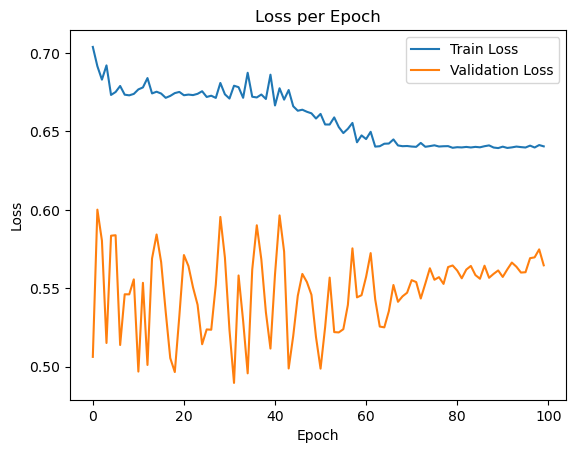

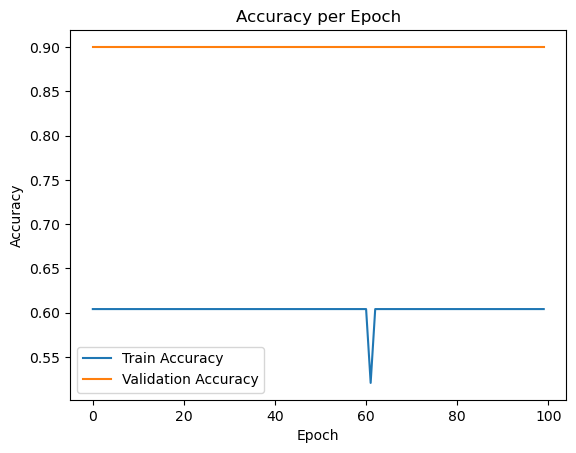

In [22]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

# Plot Train and Validation Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()